In [1]:
import sys
sys.path.append("../code/")
import util_ElasticNet, lib_LinearAlgebra, util_hdf5, util_Stats
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py, yaml
import matplotlib.pyplot as plt
from importlib import reload  
import lib_LinearAlgebra
lib_LinearAlgebra = reload(lib_LinearAlgebra)
util_ElasticNet = reload(util_ElasticNet)
util_hdf5 = reload(util_hdf5)
util_Stats = reload(util_Stats)
import util_hdf5
import logging, sys
import seaborn as sns
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr, 
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)

# Analysis overview

Building PTRS.

1. Split British data into 3 sets: training, test, validation.
2. Train least squares predictor using British training data.
3. Compute PTRS in all populations.

# Load data

In [2]:
# set path to British data
hdf5_british = '/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_British.hdf5'

# data scheme specifying which are traits and covariates
scheme_yaml = '../misc_files/data_scheme.yaml'

# loading names of traits/covariates
# the order is matched with the data being loaded
feature_dic = util_hdf5.read_yaml(scheme_yaml)
with h5py.File(hdf5_british, 'r') as f:
    features = f['columns_y'][:].astype('str')
    y = f['y'][:]
covar_indice = np.where(np.isin(features, feature_dic['covar_names']))[0]
trait_indice = np.where(np.isin(features, feature_dic['outcome_names']))[0]

In [3]:
# import scipy.stats
# def inv_norm_col(mat):
#     return np.apply_along_axis(inv_norm_vec, 0, mat)
# def inv_norm_vec(vec, offset = 1):
#     rank = myrank(vec)
#     return scipy.stats.norm.ppf(rank / (len(rank) + offset), loc = 0, scale = 1)
# def myrank(vec):
#     argsort = np.argsort(vec)
#     ranks = np.empty_like(argsort)
#     ranks[argsort] = np.arange(len(vec))
#     return ranks + 1  # rank starts from 1

In [4]:
# y_norm = inv_norm_col(y)

In [5]:
# scipy.stats.describe(y_norm[:,2])

In [6]:
features

array(['age_recruitment', 'sex', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6',
       'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14',
       'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'height', 'dbp',
       'sbp', 'bmi', 'wbc', 'rbc', 'hb', 'ht', 'mcv', 'mch', 'mchc',
       'platelet', 'lymphocyte', 'monocyte', 'neutrophil', 'eosinophil',
       'basophil', 'age_squared', 'age_times_sex',
       'age_squared_times_sex'], dtype='<U21')

In [7]:
# load data_scheme for training
batch_size = 2 ** 12
print(f'batch_size in British set is {batch_size}')
data_scheme, sample_size = util_hdf5.build_data_scheme(
    hdf5_british, 
    scheme_yaml, 
    batch_size = batch_size, 
    inv_norm_y = True
)

# set validation and test set as the first and second batch
dataset_valid = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_test = data_scheme.dataset.take(1)
data_scheme.dataset = data_scheme.dataset.skip(1)
dataset_insample = data_scheme.dataset.take(1)
# data_scheme.dataset = data_scheme.dataset.take(10)

batch_size in British set is 4096


In [8]:
data_scheme2, sample_size2 = util_hdf5.build_data_scheme(
    hdf5_british, 
    scheme_yaml, 
    batch_size = batch_size, 
    inv_norm_y = True
)

for u in data_scheme2.dataset.unbatch().batch(20):
#     print(u[0].shape)
    x, y = data_scheme2.get_data_matrix(u)
    break


In [9]:
x[:,-1]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1681.,    0.,    0.,    0.,    0., 2500.,    0.,    0.,    0.,
          0.,    0.,    0., 2304., 3969.,    0., 2809., 2916., 2916.,
       3600.,    0.], dtype=float32)>

# Training 

In [10]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True, normalizer = True)
least_square_solver.solve(logging = logging, sample_size = sample_size - batch_size * 2)

2020-02-02 10:52:17 AM  Progress 5%: 20480 / 348284
2020-02-02 10:52:18 AM  Progress 10%: 36864 / 348284
2020-02-02 10:52:18 AM  Progress 15%: 53248 / 348284
2020-02-02 10:52:19 AM  Progress 20%: 73728 / 348284
2020-02-02 10:52:20 AM  Progress 25%: 90112 / 348284
2020-02-02 10:52:21 AM  Progress 30%: 106496 / 348284
2020-02-02 10:52:22 AM  Progress 35%: 122880 / 348284
2020-02-02 10:52:22 AM  Progress 40%: 143360 / 348284
2020-02-02 10:52:23 AM  Progress 45%: 159744 / 348284
2020-02-02 10:52:24 AM  Progress 50%: 176128 / 348284
2020-02-02 10:52:25 AM  Progress 55%: 192512 / 348284
2020-02-02 10:52:26 AM  Progress 60%: 212992 / 348284
2020-02-02 10:52:27 AM  Progress 65%: 229376 / 348284
2020-02-02 10:52:27 AM  Progress 70%: 245760 / 348284
2020-02-02 10:52:28 AM  Progress 75%: 262144 / 348284
2020-02-02 10:52:29 AM  Progress 80%: 282624 / 348284
2020-02-02 10:52:30 AM  Progress 85%: 299008 / 348284
2020-02-02 10:52:31 AM  Progress 90%: 315392 / 348284
2020-02-02 10:52:32 AM  Progress 9

# Testing

## Loading other datasets

In [11]:
test_datasets = {
    'British_validation': dataset_valid,
    'British_test': dataset_test,
    'British_insample': dataset_insample,
    'Chinese': None,
    'Indian': None,
    'African': None
}
batch_size_here = 8096
for i in test_datasets.keys():
    if 'British' not in i:
        filename = f'/vol/bmd/yanyul/UKB/predicted_expression_tf2/ukb_imp_x_ctimp_Whole_Blood_{i}.hdf5'
        data_scheme, sample_size = util_hdf5.build_data_scheme(
            filename, 
            scheme_yaml, 
            batch_size = batch_size_here, 
            inv_norm_y = True
        )
        test_datasets[i] = data_scheme.dataset

## Calculate PTRS

This section is mainly for debugging.

In [12]:
# dataset = test_datasets['British_validation']
# dataset_in = test_datasets['British_insample']
# ptrs_british_valid = least_square_solver.predict_x(dataset)
# ptrs_british_in = least_square_solver.predict_x(dataset_in)

In [13]:
# least_square_solver.betahat

In [14]:
# fig, axe = plt.subplots(ncols = 3, nrows = 6, figsize = (10,20))
# for i in range(3):
#     for j in range(6):
#         k = j * 3 + i 
#         if k < 17:
#             axe[j][i].scatter(ptrs_british_valid['y'][:, k], ptrs_british_valid['y_pred_from_x'][:, k])
#             axe[j][i].title.set_text(features[trait_indice][k])
#             axe[j][i].scatter(ptrs_british_in['y'][:, k], ptrs_british_in['y_pred_from_x'][:, k])
#             axe[j][i].title.set_text(features[trait_indice][k])

## Calculate partial R2

In [15]:
partial_r2 = {}
for i in test_datasets.keys():
    dataset = test_datasets[i]
    for ele in dataset:
        x, y = least_square_solver.data_scheme.get_data_matrix(ele)
        covar = x[:, -len(least_square_solver.data_scheme.covariate_indice) :]
        print('trait = {}, ncol(covar) = {}'.format(i, covar.shape[1]))
    out = least_square_solver.predict_x(dataset)
    partial_r2[i] = util_Stats.quick_partial_r2(covar, out['y'], np.expand_dims(out['y_pred_from_x'], axis = 2))

trait = British_validation, ncol(covar) = 25
(26, 26)
trait = British_test, ncol(covar) = 25
(26, 26)
trait = British_insample, ncol(covar) = 25
(26, 26)
trait = Chinese, ncol(covar) = 25
(26, 26)
trait = Indian, ncol(covar) = 25
(26, 26)
trait = African, ncol(covar) = 25
(26, 26)


In [16]:
partial_r2['Chinese'].shape

(17, 1)

In [17]:
def _pr2_format(ele, features, name):
    return pd.DataFrame({'partial_r2': ele[:, 0], 'trait': features, 'sample': name})
df = pd.DataFrame({'partial_r2': [], 'trait': [], 'sample': []})
for i in partial_r2.keys():
    df = pd.concat((df, _pr2_format(partial_r2[i], features[trait_indice], i)))

In [18]:
df

,partial_r2,trait,sample
0,0.118363,height,British_validation
1,0.016811,dbp,British_validation
2,0.014212,sbp,British_validation
3,0.030900,bmi,British_validation
4,0.041676,wbc,British_validation
...,...,...,...
12,0.007680,lymphocyte,African
13,0.008967,monocyte,African
14,0.007251,neutrophil,African
15,0.005128,eosinophil,African


# Save partial R2

In [19]:
df

,partial_r2,trait,sample
0,0.118363,height,British_validation
1,0.016811,dbp,British_validation
2,0.014212,sbp,British_validation
3,0.030900,bmi,British_validation
4,0.041676,wbc,British_validation
...,...,...,...
12,0.007680,lymphocyte,African
13,0.008967,monocyte,African
14,0.007251,neutrophil,African
15,0.005128,eosinophil,African


In [20]:
df.to_csv('/vol/bmd/yanyul/UKB/ptrs-tf/models/partial_r2-least_square_model-ukb_imp_x_ctimp_Whole_Blood_British.tsv', sep = '\t', index = False)

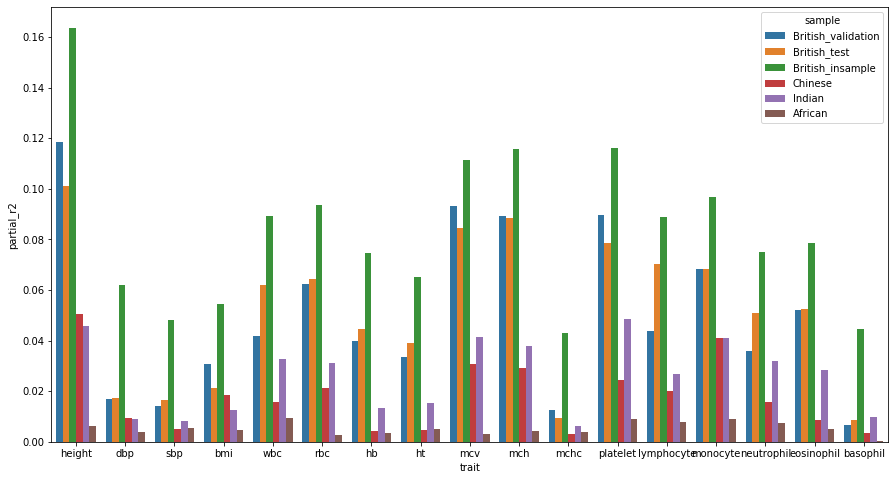

In [21]:
plt.figure(figsize=(15,8))
sns.barplot(x = "trait", y = "partial_r2", hue = 'sample', data = df)


# Load REML result

In [22]:
filename = '/vol/bmd/yanyul/UKB/gcta_regulability/reml_from_hail_martin_et_al_traits_x_ctimp_Whole_Blood_x_{pop}.tsv'
df_reml = pd.DataFrame({})
for pop in ['African', 'Chinese', 'Indian', 'British-test-1']:
    df_reml_i = pd.read_csv(filename.format(pop = pop), sep = '\t')
    if 'British' in pop:
        pop = 'British_test'
    df_reml_i['sample'] = pop
    df_reml = pd.concat((df_reml, df_reml_i))

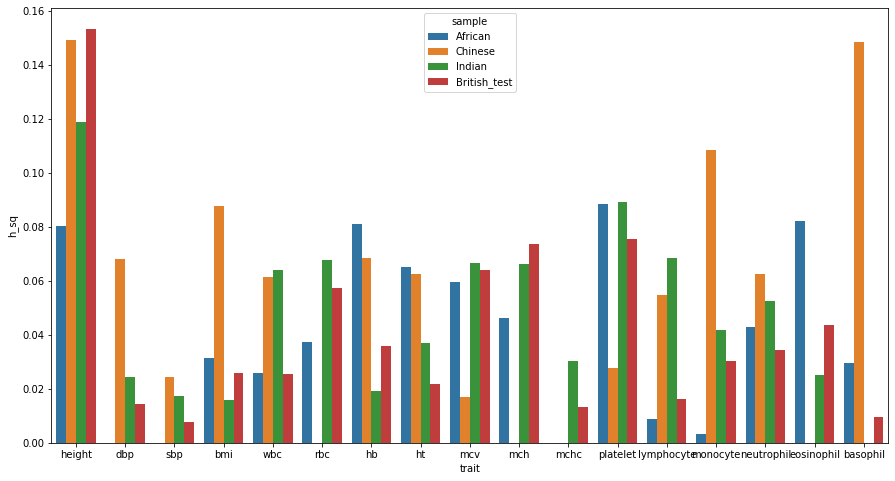

In [23]:
plt.figure(figsize=(15,8))
sns.barplot(x = "trait", y = "h_sq", hue = 'sample', data = df_reml)

# REML vs Partial R2

In [24]:
tmp = pd.read_table('/vol/bmd/yanyul/GitHub/ptrs-ukb/external_data/martin_et_al_2019ng_table_s6_trait_description.tsv', sep = '\t')
blood_traits = ['wbc', 'rbc', 'platelet', 'lymphocyte', 'monocyte', 'neutrophil', 'eosinophil', 'basophil'] 
df_join = df_reml.join(df.set_index(['trait', 'sample']), on = ['trait', 'sample'])
df_join['is_blood_cell_count'] = np.isin(df_join['trait'], blood_traits)

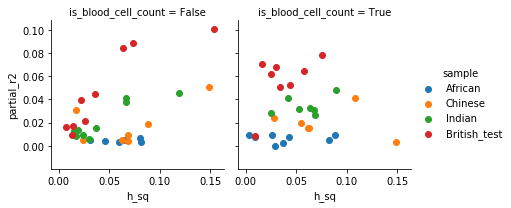

In [25]:
g = sns.FacetGrid(df_join, col = "is_blood_cell_count", hue = 'sample')  # 
g = g.map(plt.scatter, "h_sq", "partial_r2")
g.add_legend()
# plt.figure(figsize=(10,10))
# sns.scatterplot(x = "h_sq", y = "partial_r2", hue = 'trait', style = 'sample', data = df_join)